In [45]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, AveragePooling1D, Input
from keras.optimizers import Nadam
from keras.regularizers import L2

from sklearn.model_selection import train_test_split

from time import perf_counter
import functools

In [2]:
stresses = ['Gm', 'Drought', 'Nutrient_Deficiency', 'Fs', 'Salinity']

In [3]:
csv_path = r'..\combined.csv'
df = pd.read_csv(csv_path)
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
df.drop(columns=['Fungal_infection'], inplace=True, errors='ignore')
df[stresses] = df[stresses].astype(bool)

C:\Users\amitt\AppData\Local\Temp\ipykernel_4272\1297277926.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [4]:
spec_cols = [col for col in df.columns if col[0] == 'X']

In [5]:
df['Stressed'] = df[stresses].any(axis=1)

In [59]:
def drop_res(x, blur_factor=10):
    spec_x = x[:,:(x.shape[1]//blur_factor * blur_factor)]
    blur_x = (spec_x.flatten()
     .reshape((spec_x.shape[0] * spec_x.shape[1] // blur_factor, blur_factor))
     .mean(axis=1)
     .reshape((spec_x.shape[0], spec_x.shape[1] // blur_factor))
    )

    return blur_x

In [60]:
fuzzy_win = 5
fuzzy_dx_kernel = np.hstack((np.ones(fuzzy_win) * -1/fuzzy_win, np.ones(fuzzy_win)/fuzzy_win))

fuzzy_dx = np.apply_along_axis(lambda x: np.convolve(x, fuzzy_dx_kernel, mode='valid'), arr=df[spec_cols].values, axis=1)

In [68]:
# x = drop_res(df[spec_cols].values, 1)
blur_factor = 5
x = drop_res(fuzzy_dx, blur_factor=blur_factor)
y = df['Stressed']

x /= x.max()

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2)

In [62]:
model = Sequential([
    Input(shape=(x_train.shape[1],)),
    Dense(10),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Nadam(1e-3, beta_1=.5, beta_2=.7), loss='binary_crossentropy', metrics=['accuracy'])

In [63]:
start = perf_counter()

history = model.fit(
    x_train,
    y_train,
    epochs=200,
    validation_data=(x_val, y_val),
    batch_size=50,
)

print(perf_counter() - start)

Epoch 1/200
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6139 - loss: 0.6580 - val_accuracy: 0.6746 - val_loss: 0.6291
Epoch 2/200
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6885 - loss: 0.6188 - val_accuracy: 0.7460 - val_loss: 0.5959
Epoch 3/200
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7462 - loss: 0.5865 - val_accuracy: 0.7477 - val_loss: 0.5755
Epoch 4/200
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7502 - loss: 0.5656 - val_accuracy: 0.7485 - val_loss: 0.5743
Epoch 5/200
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7579 - loss: 0.5491 - val_accuracy: 0.7570 - val_loss: 0.5445
Epoch 6/200
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7662 - loss: 0.5374 - val_accuracy: 0.7599 - val_loss: 0.5365
Epoch 7/200
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7651 - loss: 0.5337 - val_accuracy: 0.7703 - val_loss: 0.5478
Epoch 8/200
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7637 - loss: 0.5321 - val_accu

In [64]:
np.unique(y_val, return_counts=True)[1] / y_val.shape[0]

array([0.386306, 0.613694])

Text(0.5, 1.0, 'Accuracy over Training')

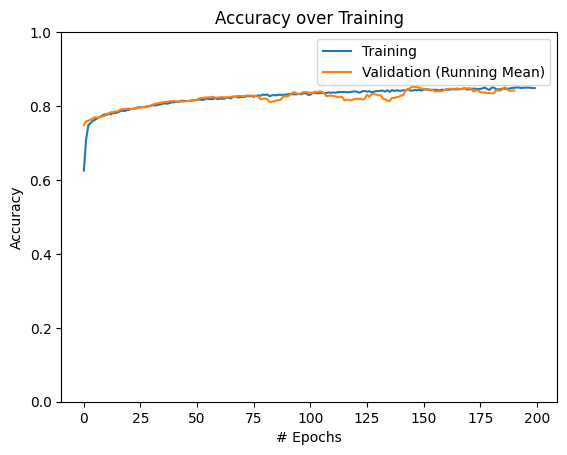

In [65]:
fig = plt.figure()
ax = plt.gca()

ax.plot(history.history['accuracy'], label='Training')
ax.plot(
    np.convolve(np.array(history.history['val_accuracy']), np.ones(10)/10, mode='valid'),
    label='Validation (Running Mean)'
)
ax.legend()
ax.set_xlabel('# Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim((0, 1))
ax.set_title('Accuracy over Training')

Text(0.5, 0.98, 'Dense Weights')

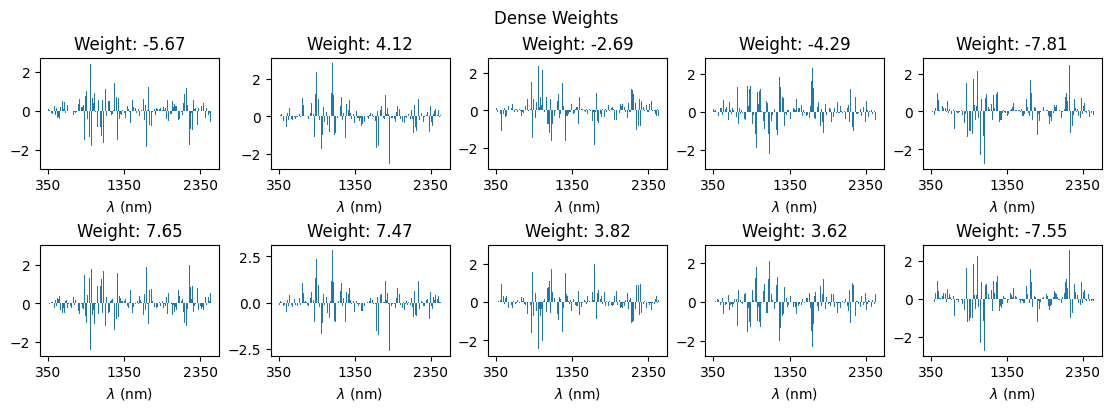

In [88]:
fig, axs = plt.subplots(2, 5, figsize=(11,4), constrained_layout=True)

i = 0
for row in axs:
    for ax in row:
        dense_weights = model.get_layer(index=0).weights[0].numpy()[:,i]
        xrange = np.arange(0, dense_weights.shape[0], 1)
        ax.bar(xrange, dense_weights, align='edge')
        step = 200
        ax.set_xticks(xrange[::step], np.array([int(x[1:]) for x in spec_cols[::blur_factor]])[np.arange(0, dense_weights.shape[0], 1)][::step])
        ax.set_xlabel(r'$\lambda$ (nm)')
        ax.set_title(f'Weight: {round(model.get_layer(index=1).weights[0].numpy()[i,0], 2):.3}')
        i += 1

fig.suptitle('Dense Weights')

In [120]:
rows = model.get_layer(index=0).weights[0].numpy().T

cols = spec_cols[::blur_factor][:rows.shape[1]]

weights_df = pd.DataFrame(rows, columns=cols)
weights_df['Layer 2 Weights'] = model.get_layer(index=1).weights[0].numpy()[:,0]

In [122]:
weights_df.to_csv('white_box_weights.csv')